# The evolutionary inception of changepoint detection and its implications for neural computation.

### Welcome to the Jupyter notebook

All code written by Travis Monk, Western Sydney University.  It is freely available for all commercial and noncommercial use. 

This notebook reproduces all simulations and figures found in the main manuscript and SI.  It takes around 3 hours to run all simulations and compile all figures on my 2017 MacBook Pro.

The notebook is divided into four main sections:  "Preamble," "Functions," "Simulations," and "Figures."  The Preamble loads necessary packages.  All packages are standard.  The Functions section defines the simulations to be run: CUSUM and the LIFN.  The Simulations section evaluates the Functions at the parameter values stated in the main text.  The Figures section loads the Simulations and reproduces the figures in the manuscript.  Simulation results are stored in the same folder as this notebook, and the figures are stored as .pdf files in the same folder as well.

Each code block in the Simulations section has a flag called run_sims.  The flag can expedite the execution of the notebook.  If users already have simulation files saved, then set the flags to False.  Then only the code blocks in Figures will run (figures are generated in around 30 seconds if simulations don't run).  Or users can select only certain simulations to run.

Users are free to change parameter values as they see fit.  But be advised that the figures are formatted for the parameter values declared in the manuscript.  Changing parameter values means that users need to change the code blocks that plot the results.

Finally, two code blocks that generate figures below load experimental data to compare it to our simulation results.  These filenames are called 

## Preamble

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rc
from matplotlib import rcParams
import matplotlib.gridspec as gridspec
import csv

% matplotlib inline

rc('text',usetex=True)
rc('font', **{'family' : "sans-serif"})
params= {'text.latex.preamble' : [r'\usepackage{amsmath}']}
plt.rcParams.update(params)

## Functions

### The classic CUSUM CPD algorithm

See Page's seminal work in the references for a derivation of this algorithm.  See Lorden and Moustakides for derivations on its minimax optimality property.

Page's work relies heavily on Abraham Wald's seminal work on sequential analysis, "On cumulative sums of random variables."  The works of Wald and Page are remarkably readable, even for readers without rigorous backgrounds in probability theory.  If you know basic martingale theory, both papers will be easy to understand.

The inputs to function "classic" are the sensory neuron's spontaneous rate L0, its detection rate L1, its threshold a, and a parameter called "trials."  Trials is the number of times we run the function until it hits the threshold, for both L0 and L1.  For example, if trials is 10, we run CUSUM with input rate L0 until it hits the threshold 10 times, and then we do it 10 more times with input rate L1.

The outputs ISI_fa and ISI_dd are lists of the waiting times to hit the threshold.  The length of each list is trials.

In [2]:
#CUSUM without ever exceeding the lower barrier
def classic(L0,L1,a,trials):
        
    #time constant and synaptic weight
    tau = 1./(L1-L0); w = L1/L0
    #store number of spikes to threshold crossing
    ISI = [];

    #both before and after CP
    for L in [L0,L1]:
        for i in range(trials):

            #log likelihood ratio, baseline, clock
            llr = 0; bl = 0; t = 0
            while llr < bl + a:

                #generate time when afferent spiked (sec)
                S = np.random.exponential(scale=1./L)
                #update time
                t += S;
                #evaluate log likelihood given ISI duration
                llr -= S / tau
                #if llr less than current baseline, update baseline
                if llr < bl:
                    bl = llr
                #then add the spike
                llr += np.log(w)

            ISI.append(t);
    #recover false alarms and detection delay
    ISI_fa = ISI[0:trials]; ISI_dd = ISI[trials::]
    
    return ISI_fa, ISI_dd

### The standard LIFN

This function simulates the standard leaky integrate-and-fire neuron as discussed thoroughly by Tony Burkitt in his popular review.

The inputs L0, L1, and trials are directly analogous to the inputs to the function "classic."  Input th is the threshold.  Input w is the EPSP amplitude (in millivolts).  The input "match" is a proportionality constant that determines whether we use Eq.\ 4 (main text) for the time constant value, or we alter it.  If match = 1, then $\tau$ is given by Eq.\ 4.  If match = .5, then $\tau$ is half the value of Eq.\ 4.

The outputs LIFN_ISI_fa and LIFN_ISI_dd record the interspike interval (in seconds) required for the LIFN to reach threshold.

In [3]:
#classic LIFN.  if match = 1, the LIFN time constant matches the input rates
def LIFN(L0,L1,w,th,trials,match):
    
    #set time constant
    tau = 1./(L1-L0)*match;
        
    LIFN_ISI = []

    for L in [L0,L1]:
        for i in range(trials):
            #likelihood ratio, baseline, clock
            lr = 0; bl = 0; t = 0; s = 0
            while lr < bl + th:

                #generate time when afferent spiked (sec)
                S = np.random.exponential(scale=1./L)
                #update time
                t += S
                #evaluate voltage just before the spike
                lr *= np.exp(-S/tau)
                #evaluate voltage after the spike
                lr += w

            LIFN_ISI.append(t)
    #recover false alarms and detection delay
    LIFN_ISI_fa = LIFN_ISI[0:trials]; LIFN_ISI_dd = LIFN_ISI[trials::]
    
    return LIFN_ISI_fa, LIFN_ISI_dd

# Simulations

## CUSUM - Figs. 3 and 6

This simulation block evaluates the function "classic," extracts the first and second moments of waiting times, and then takes the Fourier transform of simulation results.  It does this for the parameter values stated in the manuscript.  Then it saves the simulation results, each set of parameter values gets its own unique filename.

a_prop is a proportionality constant relating the CUSUM threshold $a$ to $\ln(\lambda_1/\lambda_0)$.  For example, if a_prop = 2, then $a = 2\ln(\lambda_1/\lambda_0)$.

This code block runs the simulations plotted in Fig. 3 of the manuscript.

In [4]:
#run CUSUM simulations in this block if needed (reproduces data from figure 3 main text)
run_sims = True;

L1_list = [600.,1000.,8000.]; L0_list = [200.,500.,2000.]; a_prop = 2; trials = 50000

#independent variable of Fourier transforms
t_alter = [np.linspace(-i,i,10001)*1j for i in [5000,5000,10000]]

if run_sims == True:
    
    for y in range(len(L1_list)):
            
        L1 = L1_list[y]; L0 = L0_list[y]; a = a_prop*np.log(L1/L0); t = t_alter[y]

        ISI_fa, ISI_dd = classic(L0,L1,a,trials)

        #save first and second moment of time
        ES_FA_sim = np.mean(ISI_fa); ES_DD_sim = np.mean(ISI_dd)
        ES2_FA_sim = np.mean([i**2 for i in ISI_fa])
        ES2_DD_sim = np.mean([i**2 for i in ISI_dd])

        #take the fourier transform
        FT_ISI_fa = np.array([np.mean(np.exp(np.array(ISI_fa)*j)) for j in t])
        FT_ISI_dd = np.array([np.mean(np.exp(np.array(ISI_dd)*j)) for j in t])

        filename = 'classic_L1_' + str(int(L1)) + '_L0_' + str(int(L0)) + \
                    '_a_' + str(a_prop) +  '.npz'
        np.savez(filename,L1=L1,L0=L0,a=a,t=t,\
                 ISI_fa=FT_ISI_fa,ISI_dd=FT_ISI_dd,\
                 ES_FA_sim=ES_FA_sim,ES_DD_sim=ES_DD_sim,\
                 ES2_FA_sim=ES2_FA_sim,ES2_DD_sim=ES2_DD_sim)

## LIFN - Fig. 3

This simulation block is analogous to the one above, except it runs the LIFN function.  We compare these LIFN results below with the CUSUM results in the block above in Fig. 3.

In [5]:
#run LIFN simulations if needed (reproduces data from figure 3 main text).
#the parameter values used in the figure are:
#L1 = 600, L0 = 200, a = 2log(w) -> w = 34.26.  
#L1 = 1000, L0 = 500, a = 2log(w) -> w = 29.17. 
#L1 = 8000, L0 = 2000, a = 2log(w) -> w = 36.08.  

run_sims = True;

L1_list = [600.,1000.,8000.]; L0_list = [200.,500.,2000.]; 
w_list= [34.26,29.17,36.08]; trials = 50000; th = 70.

#independent variable of Fourier transforms
t_alter = [np.linspace(-i,i,10001)*1j for i in [5000,5000,10000]]

if run_sims == True:
    
    for y in range(len(w_list)):

        L1 = L1_list[y]; L0 = L0_list[y]; t = t_alter[y]; w = w_list[y];

        LIFN_ISI_fa, LIFN_ISI_dd = LIFN(L0,L1,w,th,trials,1)

        ES_FA = np.mean(LIFN_ISI_fa); ES_DD = np.mean(LIFN_ISI_dd)
        ES2_FA = np.mean([i**2 for i in LIFN_ISI_fa]); ES2_DD = np.mean([i**2 for i in LIFN_ISI_dd])

        FT_LIFN_ISI_fa = np.array([np.mean(np.exp(np.array(LIFN_ISI_fa)*j)) for j in t])
        FT_LIFN_ISI_dd = np.array([np.mean(np.exp(np.array(LIFN_ISI_dd)*j)) for j in t])

        filename = 'LIFN_L1_' + str(int(L1)) + '_L0_' + str(int(L0)) + \
                    '_w_' + str(w) +  '.npz'
        np.savez(filename,L1=L1,L0=L0,w=w,t=t,LIFN_ISI_fa=FT_LIFN_ISI_fa,LIFN_ISI_dd=FT_LIFN_ISI_dd,\
                 LIFN_ES_FA=ES_FA,LIFN_ES_DD=ES_DD,LIFN_ES2_FA=ES2_FA,LIFN_ES2_DD=ES2_DD)

## Barn owl NMN simulations

This code block evaluates the "classic" function to reproduce the figure from the NMN section of the main text.  It then runs the "LIFN" function to compare them.  Simulations are run for the given parameter values, then it extracts false alarm and detection delay expectations for both functions.  It takes the Fourier transform of results and saves them for plotting later.  These simulation results are plotted in Fig. 4 of the manuscript.

In [6]:
#figure 4 data, main text
run_sims = True

if run_sims == True:

    #run CUSUM with barn-owl-relevant parameter values
    L0 = 140.; L1 = 240.; n = 5; a = 1.1*np.log(L1/L0); trials = 100000; w = 41.38; match = 1.1; th = 70.

    ISI_fa, ISI_dd = classic(L0*n,L1*n,a,trials)
    NM_fa, NM_dd = LIFN(n*L0,n*L1,w,th,trials,match)

    #expectations
    NMN_fa = 1./np.mean(NM_fa); NMN_dd = 1./np.mean(NM_dd)
    ES_fa = 1./np.mean(ISI_fa); ES_dd = 1./np.mean(ISI_dd)

    print "CUSUM: ", 1./np.mean(ISI_fa), 1./np.mean(ISI_dd)
    print "LIFN: ", 1./np.mean(NM_fa), 1./np.mean(NM_dd)

    #Fourier transforms
    towl = np.linspace(-2000,2000,1000)*1j
    FT_ISI_fa = np.array([np.mean(np.exp(np.array(ISI_fa)*j)) for j in towl])
    FT_ISI_dd = np.array([np.mean(np.exp(np.array(ISI_dd)*j)) for j in towl])
    FT_NM_fa = np.array([np.mean(np.exp(np.array(NM_fa)*j)) for j in towl])
    FT_NM_dd = np.array([np.mean(np.exp(np.array(NM_dd)*j)) for j in towl])

    #exponential approximations
    page_fa = NMN_fa/(NMN_fa - towl); page_dd = NMN_dd/(NMN_dd - towl)
    
    np.savez('barn_owl.npz',towl=towl,page_fa=page_fa,page_dd=page_dd,\
            FT_ISI_fa=FT_ISI_fa,FT_ISI_dd=FT_ISI_dd,FT_NM_fa=FT_NM_fa,FT_NM_dd=FT_NM_dd,\
            ISI_fa=ISI_fa,ISI_dd=ISI_dd,ES_fa=ES_fa,ES_dd=ES_dd,NMN_fa=NMN_fa,NMN_dd=NMN_dd)

CUSUM:  231.556210132 488.505876477
LIFN:  245.48853328 493.893006482


## Altering $\tau$ when EPSPs are smaller compared to threshold - CUSUM

This code block runs CUSUM for four values of $\lambda_1$, $\lambda_0$, and $a$.  Each set of values is stored in a separate file.  These simulation results are plotted in Fig. 5 of the manuscript.

In [7]:
#run CUSUM simulations in this block if needed (reproduces data from figure 5 main text)
run_sims = True;

L1_list = [40.,600.,2.,2.]; L0_list = [10.,200.,1.,1.]; a_prop = [5,5,5,8]; trials = 50000

t_alter = [np.linspace(-i,i,50001)*1j for i in [50,5000,5,.5]]

if run_sims == True:

    for y in range(len(L1_list)):
        
        L1 = L1_list[y]; L0 = L0_list[y]; a = a_prop[y]*np.log(L1/L0); t = t_alter[y]

        ISI_fa, ISI_dd = classic(L0,L1,a,trials)

        #save first and second moment of time
        ES_FA_sim = np.mean(ISI_fa); ES_DD_sim = np.mean(ISI_dd)
        ES2_FA_sim = np.mean([i**2 for i in ISI_fa])
        ES2_DD_sim = np.mean([i**2 for i in ISI_dd])

        #take the fourier transform
        FT_ISI_fa = np.array([np.mean(np.exp(np.array(ISI_fa)*j)) for j in t])
        FT_ISI_dd = np.array([np.mean(np.exp(np.array(ISI_dd)*j)) for j in t])

        filename = 'classic_L1_' + str(int(L1)) + '_L0_' + str(int(L0)) + \
                    '_a_' + str(a_prop[y]) +  '.npz'
        np.savez(filename,L1=L1,L0=L0,a=a,t=t,\
                 ISI_fa=FT_ISI_fa,ISI_dd=FT_ISI_dd,\
                 ES_FA_sim=ES_FA_sim,ES_DD_sim=ES_DD_sim,\
                 ES2_FA_sim=ES2_FA_sim,ES2_DD_sim=ES2_DD_sim)

## Altering $\tau$ when EPSPs are smaller compared to threshold - LIFN

This code block is analogous to the one above, except we run the LIFN function instead of CUSUM.

We run the LIFN functions for two LIFNs.  One has a time constant given by Eqs.\ 4, and the other has a larger time constant.  The input parameter "match" is a proportionality constant relating the time constant given by Eqs.\ 4 and the time constant value used in the simulation.  For example, if match = 2, $\lambda_1 = 10$, and $\lambda_0 = 5$, then $\tau = 1/2$ by Eqs.\ 4, and $\tau' = 2(1/2) = 1$.

Again, simulation results from each set of parameter values is saved in a separate file.  Those results are compared to the CUSUM results above in Fig. 5 of the manuscript.

In [8]:
#run LIFN simulations if needed (reproduces data from figure 5 main text).

#the parameter values used in the figure are:
#L1 = 40, L0 = 10, a = 5log(w) -> w = 20.91, match = 1
#L1 = 600, L0 = 200, a = 5log(w) -> w = 20.27, match = 1
#L1 = 2, L0 = 1, a = 5log(w) -> w = 17.79, match = 1
#L1 = 2, L0 = 1, a = 8log(w) -> w = 14.29, match = 1

#L1 = 40, L0 = 10, a = 5log(w) -> w = 12.66, match = 4
#L1 = 600, L0 = 200, a = 5log(w) -> w = 13.08, match = 3
#L1 = 2, L0 = 1, a = 5log(w) -> w = 12.87, match = 2
#L1 = 2, L0 = 1, a = 8log(w) -> w = 6.27, match = 5

run_sims = True;

L1_list = [40.,600.,2.,2.]; L0_list = [10.,200.,1.,1.]; 
w_list = [[20.91,20.27,17.79,14.29],[12.66,13.08,12.87,6.27]]; match_list = [[1,1,1,1],[4,3,2,5]]
trials = 50000; th = 70.

t_alter = [np.linspace(-i,i,50001)*1j for i in [50,5000,5,.5]]

if run_sims == True:
    
    for z in range(2):
        for y in range(len(L1_list)):

            L1 = L1_list[y]; L0 = L0_list[y]; w = w_list[z][y]; t = t_alter[y]; match = match_list[z][y]

            LIFN_ISI_fa, LIFN_ISI_dd = LIFN(L0,L1,w,th,trials,match)

            ES_FA = np.mean(LIFN_ISI_fa); ES_DD = np.mean(LIFN_ISI_dd)
            ES2_FA = np.mean([i**2 for i in LIFN_ISI_fa]); ES2_DD = np.mean([i**2 for i in LIFN_ISI_dd])

            FT_LIFN_ISI_fa = np.array([np.mean(np.exp(np.array(LIFN_ISI_fa)*j)) for j in t])
            FT_LIFN_ISI_dd = np.array([np.mean(np.exp(np.array(LIFN_ISI_dd)*j)) for j in t])

            filename = 'LIFN_L1_' + str(int(L1)) + '_L0_' + str(int(L0)) + \
                        '_w_' + str(w) +  '_match_' + str(match) + '.npz'
            np.savez(filename,L1=L1,L0=L0,w=w,t=t,LIFN_ISI_fa=FT_LIFN_ISI_fa,LIFN_ISI_dd=FT_LIFN_ISI_dd,\
                     LIFN_ES_FA=ES_FA,LIFN_ES_DD=ES_DD,LIFN_ES2_FA=ES2_FA,LIFN_ES2_DD=ES2_DD)

## One Optimal value of $\tau$ gives the closest fit between CUSUM and a LIFN

This code block runs LIFN simulation results where we systematically vary $\tau$.  We also vary $w$ such that the false alarm waiting times remain the same despite changing the value of $\tau$.  

These results are compared with CUSUM's results in Fig. 6 of the manuscript.  We ran the CUSUM results in an earlier block, so we will simply load them and re-plot them later instead of running them again.

In [9]:
#parameter values used in the figure
#L1 = 600, L0 = 200
#a = 2, match = .2, w = 50.72
#a = 2, match = .5, w = 40.00 
#a = 2, match = 1, w = 34.26
#a = 2, match = 2, w = 26.75
#a = 2, match = 5, w = 18.17

run_sims = True;

L1 = 600.; L0 = 200.; w_list = [50.72,40.00,34.26,26.75,18.17]
match_list = [.2,.5,1,2,5]; trials = 50000; th = 70.

t = np.linspace(-300,300,5001)*1j

if run_sims == True:

    for y in range(len(w_list)):

        w = w_list[y]; match = match_list[y]

        LIFN_ISI_fa, LIFN_ISI_dd = LIFN(L0,L1,w,th,trials,match)

        ES_FA = np.mean(LIFN_ISI_fa); ES_DD = np.mean(LIFN_ISI_dd)
        ES2_FA = np.mean([i**2 for i in LIFN_ISI_fa]); 
        ES2_DD = np.mean([i**2 for i in LIFN_ISI_dd])

        FT_LIFN_ISI_fa = np.array([np.mean(np.exp(np.array(LIFN_ISI_fa)*j)) for j in t])
        FT_LIFN_ISI_dd = np.array([np.mean(np.exp(np.array(LIFN_ISI_dd)*j)) for j in t])

        filename = 'LIFN_vary_L1_' + str(int(L1)) + '_L0_' + str(int(L0)) + \
                        '_w_' + str(w) +  '_match_' + str(match) + '.npz'

        np.savez(filename,L1=L1,L0=L0,t=t,w=w,LIFN_ISI_fa=FT_LIFN_ISI_fa,LIFN_ISI_dd=FT_LIFN_ISI_dd,\
                 LIFN_ES_FA=ES_FA,LIFN_ES_DD=ES_DD,LIFN_ES2_FA=ES2_FA,LIFN_ES2_DD=ES2_DD,match=match)

## Barn owl NLN simulations

This code block evaluates the CUSUM and LIFN functions to reproduce Fig.\ 7 in the manuscript.  Simulations are run for the parameter values stated in the main text, then it extracts false alarm and detection delay expectations for both functions.  It takes the Fourier transform of results and saves them for plotting later.

In [10]:
#run CUSUM and LIFN with laminaris-relevant parameter values
run_sims = True

if run_sims == True:

    #input rates (sum of Poissons is Poisson)
    L0 = float(50000); L1 = float(70000)
    #CUSUM threshold
    a = 17*np.log(L1/L0); trials = 100000; 
    #LIFN synaptic weight, tau proportionality constant, threshold
    w = 2.74; match = 6; th = 70.

    ISI_fa, ISI_dd = classic(L0,L1,a,trials)
    NL_fa, NL_dd = LIFN(L0,L1,w,th,trials,match)
    
    #expectations
    ES_fa = 1./np.mean(ISI_fa); ES_dd = 1./np.mean(ISI_dd)
    NLN_fa = 1./np.mean(NL_fa); NLN_dd = 1./np.mean(NL_dd)

    #Fourier transforms
    tnl_fa = np.linspace(-250,250,1000)*1j
    tnl_dd = np.linspace(-10000,10000,1000)*1j
    FT_ISI_fa = np.array([np.mean(np.exp(np.array(ISI_fa)*j)) for j in tnl_fa])
    FT_ISI_dd = np.array([np.mean(np.exp(np.array(ISI_dd)*j)) for j in tnl_dd])
    FT_NL_fa = np.array([np.mean(np.exp(np.array(NL_fa)*j)) for j in tnl_fa])
    FT_NL_dd = np.array([np.mean(np.exp(np.array(NL_dd)*j)) for j in tnl_dd])
    
    #exponential approximations
    page_fa = NLN_fa/(NLN_fa - tnl_fa)
    page_dd = NLN_dd/(NLN_dd - tnl_dd)
    
    np.savez('NL.npz',ISI_fa=ISI_fa,ISI_dd=ISI_dd,\
             FT_ISI_fa=FT_ISI_fa,FT_ISI_dd=FT_ISI_dd,ES_fa=ES_fa,ES_dd=ES_dd,\
             FT_NL_fa=FT_NL_fa,FT_NL_dd=FT_NL_dd,NLN_fa=NLN_fa,NLN_dd=NLN_dd,\
             L0=L0,L1=L1,a=a,trials=trials,tnl_fa=tnl_fa,tnl_dd=tnl_dd,\
             page_fa=page_fa,page_dd=page_dd)

# Figures

The following code blocks each produce one figure from the main text.

## Schematic of CPD
Fig. 2 main text.

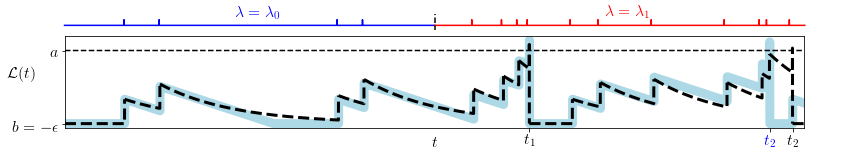

In [10]:
spikes = np.zeros(shape=10000); 
where = [0,804,1279,3682,4025,5501,5902,6108,6249,6829,7205,7925,8910,9382,9481,9790,10000]
spikes[where[1:-1]] = 1

plt.figure(figsize=(13,2))
gs1 = gridspec.GridSpec(1,1)
gs1.update(left = 0.08, right = .95, top = .93, bottom = .82)
ax1 = plt.subplot(gs1[0])
ax1.plot(np.arange(0,5000),spikes[0:5000],'b'); plt.ylim([-.8,2]);
ax1.plot(np.arange(5000,10000),spikes[5000::],'r'); plt.axis('off');
ax1.plot(5000*np.ones(shape=10),np.linspace(-1,2,10),'k--')
ax1.text(2300,1.2,r'$\lambda=\lambda_0$',fontsize=16,color='b');
ax1.text(7300,1.2,r'$\lambda=\lambda_1$',fontsize=16,color='r');

slope = .001; theta = 3
Lt = [0]
for i in range(len(spikes)):
    Lt.append( np.max([0,Lt[-1]-slope])*(spikes[i]==0) + (Lt[-1]+1)*(spikes[i]==1) )
    if Lt[-1] > theta:
        Lt.append(0)

gs2 = gridspec.GridSpec(1,1)
gs2.update(left = .12, right = .91, top = .78, bottom = .14)
ax2 = plt.subplot(gs2[0])
ax2.plot(Lt[0:-1],'lightblue',lw=9);

last = 0
for i in range(1,len(where)):
    ind = np.arange(where[i-1],where[i]);
    Lt2 = last * np.exp(-.001*(ind - ind[0])); Lt2[-1] = Lt2[-1] + 1
    if Lt2[-1] > theta:
        Lt2 = np.append(Lt2,np.array([0])); ind = np.append(ind,np.array([ind[-1]+1]))
    last = Lt2[-1];
    ax2.plot(ind,Lt2,color='k',ls='--',lw=3)


ax2.plot(np.arange(0,10000),3*np.ones(shape=10000),'k--')
ax2.set_xlim([0,9949]); ax2.set_xticks([6249,9481,9790]); 
ax2.set_xticklabels([r'$t_1$',r'$t_2$',r'$t_2$'],fontsize=16)
ax2.set_yticks([0,3]); ax2.set_yticklabels([r'$b=-\epsilon$',r'$a$'],fontsize=16)
ax2.set_ylabel(r'$\mathcal{L}(t)$',fontsize=16,rotation=0,labelpad=-10)
ax2.set_xlabel(r'$t$',fontsize=16,labelpad=-15)

colors = ['k', 'b', 'k']
for xtick, color in zip(ax2.get_xticklabels(), colors):
    xtick.set_color(color)

plt.savefig('fig2.pdf')

## LIFN vs CUSUM (large EPSPs compared to threshold)

Fig. 3 main text

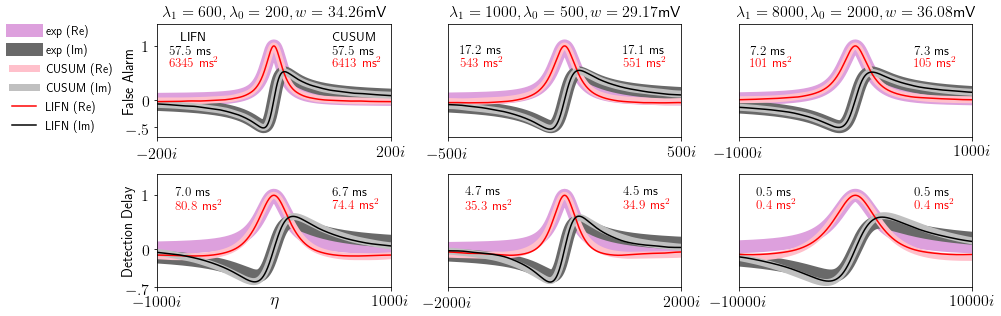

In [18]:
plt.figure(figsize=(14,4.5))

L1_list = [600.,1000.,8000.]; L0_list = [200.,500.,2000.]; w_list = [34.26,29.17,36.08]; a_prop = 2
fa_xlim = [200,500,1000]; dd_xlim = [1000,2000,10000] 

for j in range(len(L1_list)):

    L1 = L1_list[j]; L0 = L0_list[j]; w = w_list[j]; a = a_prop

    #load CUSUM simulation results
    filename = 'classic_L1_' + str(int(L1)) + '_L0_' + str(int(L0)) + \
                    '_a_' + str(int(a)) + '.npz'
    with np.load(filename) as data:
        ISI_fa = data['ISI_fa']; ISI_dd = data['ISI_dd']; a = data['a'];
        ES_FA_sim=data['ES_FA_sim']; ES_DD_sim=data['ES_DD_sim'];
        ES2_FA_sim=data['ES2_FA_sim']; ES2_DD_sim=data['ES2_DD_sim']; t_c = data['t']
        

    #load LIFN simulation results
    filename = 'LIFN_L1_' + str(int(L1)) + '_L0_' + str(int(L0)) + \
                    '_w_' + str(w) + '.npz'
    with np.load(filename) as data:
        LIFN_fa = data['LIFN_ISI_fa']; LIFN_dd = data['LIFN_ISI_dd']; w = data['w'];
        LIFN_ES_FA = data['LIFN_ES_FA']; LIFN_ES_DD = data['LIFN_ES_DD']; 
        LIFN_ES2_FA = data['LIFN_ES2_FA']; LIFN_ES2_DD = data['LIFN_ES2_DD']; t_l = data['t']

    page_fa_cusum = (1./ES_FA_sim) / (1./ES_FA_sim - t_c); page_dd_cusum = (1./ES_DD_sim) / (1./ES_DD_sim - t_c)

    
    #plot false alarms
    plt.subplot(2,3,j+1)
    plt.plot(np.imag(t_c),np.real(page_fa_cusum),'plum',lw=13,label='exp (Re)')
    plt.plot(np.imag(t_c),np.imag(page_fa_cusum),'dimgray',lw=13,label='exp (Im)')
    plt.plot(np.imag(t_c),np.real(ISI_fa),'pink',lw=7,label='CUSUM (Re)')
    plt.plot(np.imag(t_c),np.imag(ISI_fa),'silver',lw=7,label='CUSUM (Im)')
    plt.plot(np.imag(t_l),np.real(LIFN_fa),'r-',label='LIFN (Re)')
    plt.plot(np.imag(t_l),np.imag(LIFN_fa),'k-',label='LIFN (Im)')
    plt.xlim([-fa_xlim[j],fa_xlim[j]])
    plt.xticks([-fa_xlim[j],fa_xlim[j]],\
               [r'${}i$'.format(-fa_xlim[j]),r'${}i$'.format(fa_xlim[j])],fontsize=16)
    plt.ylim([-.7,1.4]); 
    if (j==0):
        plt.yticks([-.5,0,1],[r'$-.5$',r'$0$',r'$1$'],fontsize=16)
        plt.legend(loc=1,ncol=1,bbox_to_anchor=(-.3,.6,.15,.5),frameon=False,fontsize=12)
    else:
        plt.yticks([])
        
    plt.title(r'$\lambda_1 = {}$'.format(int(L1_list[j])) + r'$,  \lambda_0 = {}$'.format(int(L0_list[j])) +\
             r'$,  w = {}$'.format(w)+'mV' ,fontsize=16)

    #CUSUM and LIFN first and second moments
    if (j == 0):
        plt.text(.5*fa_xlim[j],1.1,r'CUSUM',fontsize=13)
        plt.text(-.8*fa_xlim[j],1.1,r'LIFN',fontsize=13)
        plt.ylabel(r'False Alarm',fontsize=14,labelpad=-10)
        
    plt.text(.5*fa_xlim[j],.85,r"${}$".format(round(ES_FA_sim*1000,1))+r'$\text{ ms}$',fontsize=13)
    plt.text(-.9*fa_xlim[j],.85,r"${}$".format(round(LIFN_ES_FA*1000,1))+r'$\text{ ms}$',fontsize=13)
    plt.text(.5*fa_xlim[j],.6,r"${}$".format(int(ES2_FA_sim*1000**2))+r'$\text{ ms}^2$',fontsize=13,color='r')
    plt.text(-.9*fa_xlim[j],.6,r"${}$".format(int(LIFN_ES2_FA*1000**2))+r'$\text{ ms}^2$',fontsize=13,color='r')

    #plot detection delays
    plt.subplot(2,3,j+4)
    plt.plot(np.imag(t_c),np.real(page_dd_cusum),'plum',lw=13)
    plt.plot(np.imag(t_c),np.imag(page_dd_cusum),'dimgray',lw=13)
    plt.plot(np.imag(t_c),np.real(ISI_dd),'pink',lw=7)
    plt.plot(np.imag(t_c),np.imag(ISI_dd),'silver',lw=7)
    plt.plot(np.imag(t_l),np.real(LIFN_dd),'r-')
    plt.plot(np.imag(t_l),np.imag(LIFN_dd),'k-')
    plt.xlim([-dd_xlim[j],dd_xlim[j]])
    plt.ylim([-.7,1.4]); plt.yticks([]);
    plt.xticks([-dd_xlim[j],dd_xlim[j]],\
               [r'${}i$'.format(-dd_xlim[j]),r'${}i$'.format(dd_xlim[j])],fontsize=16)
    if (j==0):
        plt.xlabel(r'$\eta$',fontsize=18,labelpad=-18)
        plt.ylabel(r'Detection Delay',fontsize=14,labelpad=-10)
        plt.yticks([-.7,0,1],[r'$-.7$',r'$0$',r'$1$'],fontsize=16)
    
    #CUSUM and LIFN first and second moments
    plt.text(.5*dd_xlim[j],1,r"${}$".format(round(ES_DD_sim*1000,1))+r'$\text{ ms}$',fontsize=13)
    plt.text(-.85*dd_xlim[j],1,r"${}$".format(round(LIFN_ES_DD*1000,1))+r'$\text{ ms}$',fontsize=13)
    plt.text(.5*dd_xlim[j],.75,r"${}$".format(round(ES2_DD_sim*1000**2,1))+r'$\text{ ms}^2$',fontsize=13,color='r')
    plt.text(-.85*dd_xlim[j],.75,r"${}$".format(round(LIFN_ES2_DD*1000**2,1))+r'$\text{ ms}^2$',fontsize=13,color='r')
    
plt.tight_layout()
plt.savefig('fig3.pdf')

## Barn owl NMN results

Fig. 4, main text.

This code block also loads experimental results from two other manuscripts.  Those experimental results are the files "Carr.csv" and "Koppl.csv".  The citations of those manuscripts can be found in the caption of Fig. 4 in the manuscript.  Be sure that the data files that this block loads is in the same directory as this notebook.

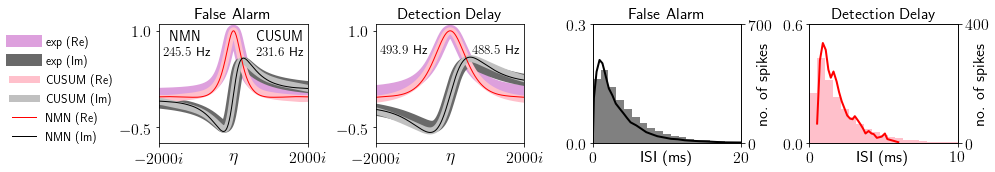

In [24]:
with np.load('barn_owl.npz') as data:
    towl = data['towl']; page_fa = data['page_fa']; page_dd = data['page_dd'];
    FT_ISI_fa = data['FT_ISI_fa']; FT_ISI_dd = data['FT_ISI_dd'];
    FT_NM_fa = data['FT_NM_fa']; FT_NM_dd = data['FT_NM_dd'];
    ISI_fa = data['ISI_fa']; ISI_dd = data['ISI_dd'];
    ES_fa = data['ES_fa']; ES_dd = data['ES_dd']; 
    NMN_fa = data['NMN_fa']; NMN_dd = data['NMN_dd']

plt.figure(figsize=(14,2.5))

plt.subplot(1,4,1)
plt.plot(np.imag(towl),np.real(page_fa),'plum',lw=12,label='exp (Re)')
plt.plot(np.imag(towl),np.imag(page_fa),'dimgray',lw=12,label='exp (Im)')
plt.plot(np.imag(towl),np.real(FT_ISI_fa),'pink',lw=7,label='CUSUM (Re)')
plt.plot(np.imag(towl),np.imag(FT_ISI_fa),'silver',lw=7,label='CUSUM (Im)')
plt.plot(np.imag(towl),np.real(FT_NM_fa),'red',lw=1,label='NMN (Re)')
plt.plot(np.imag(towl),np.imag(FT_NM_fa),'black',lw=1,label='NMN (Im)')
plt.xlim([-2000,2000]); plt.xticks([-2000,2000],[r'$-2000i$',r'$2000i$'],fontsize=16)
plt.ylim([-.75,1.1]); plt.yticks([-.5,1],fontsize=16)
plt.legend(loc=1,ncol=1,bbox_to_anchor=(-.4,.5,.15,.5),frameon=False,fontsize=12)
plt.xlabel(r'$\eta$',fontsize=18,labelpad=-18)
plt.title('False Alarm', fontsize=16)
                  
plt.text(-.85*2000,.85,r"NMN",fontsize=14)
plt.text(.3*2000,.85,r"CUSUM",fontsize=14)
plt.text(.3*2000,.6,r'${}$'.format(round(ES_fa,1))+r'$\text{ Hz}$',fontsize=13)
plt.text(-.95*2000,.6,r'${}$'.format(round(NMN_fa,1))+r'$\text{ Hz}$',fontsize=13)

plt.subplot(1,4,2)
plt.plot(np.imag(towl),np.real(page_dd),'plum',lw=12)
plt.plot(np.imag(towl),np.imag(page_dd),'dimgray',lw=12)
plt.plot(np.imag(towl),np.real(FT_ISI_dd),'pink',lw=7)
plt.plot(np.imag(towl),np.imag(FT_ISI_dd),'silver',lw=7)
plt.plot(np.imag(towl),np.real(FT_NM_dd),'red',lw=1)
plt.plot(np.imag(towl),np.imag(FT_NM_dd),'black',lw=1)
plt.xlim([-2000,2000]); plt.xticks([-2000,2000],[r'$-2000i$',r'$2000i$'],fontsize=16)
plt.ylim([-.75,1.1]); plt.yticks([-.5,1],fontsize=16)
plt.xlabel(r'$\eta$',fontsize=18,labelpad=-18)
plt.title('Detection Delay', fontsize=16)
                  
plt.text(.3*2000,.63,r'${}$'.format(round(ES_dd,1))+r'$\text{ Hz}$',fontsize=13)
plt.text(-.95*2000,.63,r'${}$'.format(round(NMN_dd,1))+r'$\text{ Hz}$',fontsize=13)


#units of ISIs in milliseconds
FA = 1000*np.array(ISI_fa); DD = 1000*np.array(ISI_dd)

ax3 = plt.subplot(1,4,3)
ax3.hist(FA,bins=np.linspace(0,20,20),density=True,color='gray');
ax3.set_xticks([0,20]); ax3.set_yticks([0,.3]); ax3.set_xlim([0,20])
ax3.tick_params(axis='x',labelsize=16); ax3.tick_params(axis='y',labelsize=16);
ax3.set_xlabel(r'ISI (ms)',fontsize=16,labelpad=-16)
ax3.set_title(r'False Alarm',fontsize=16)

ax4 = ax3.twinx()
#load experimental data
koppl_x=[]; koppl_y=[]
with open('Koppl.csv', 'r') as csvfile:
    plots= csv.reader(csvfile, delimiter=',')
    for row in plots:
        koppl_x.append(float(row[0]))
        koppl_y.append(float(row[1]))

ax4.set_ylabel('no. of spikes',fontsize=16,labelpad=-16)
ax4.plot(koppl_x, koppl_y, color='k',lw=2,label='exp')
ax4.set_yticks([0,700]); ax4.set_ylim([0,700])
ax4.tick_params(axis='y', labelsize=16)

ax5 = plt.subplot(1,4,4)
ax5.hist(DD,bins=np.linspace(0,10,20),density=True,color='pink');
ax5.set_xticks([0,10]); ax5.set_yticks([0,.6]); ax5.set_xlim([0,10])
ax5.tick_params(axis='x',labelsize=16); ax5.tick_params(axis='y',labelsize=16);
ax5.set_xlabel(r'ISI (ms)',fontsize=16,labelpad=-16)
ax5.set_title(r'Detection Delay',fontsize=16)

ax6 = ax5.twinx()
#load experimental data
carr_x=[]; carr_y=[]
with open('Carr.csv', 'r') as csvfile:
    plots= csv.reader(csvfile, delimiter=',')
    for row in plots:
        carr_x.append(float(row[0]))
        carr_y.append(float(row[1]))

ax6.set_ylabel('no. of spikes',fontsize=16,labelpad=-16)
ax6.plot(carr_x, carr_y, color='r',lw=2,label='exp')
ax6.set_yticks([0,400]); ax6.set_ylim([0,400])
ax6.tick_params(axis='y', labelsize=16)

plt.tight_layout()
plt.savefig('fig4.pdf')

## Altering $\tau$ when EPSPs are smaller compared to threshold

Fig. 5, main text

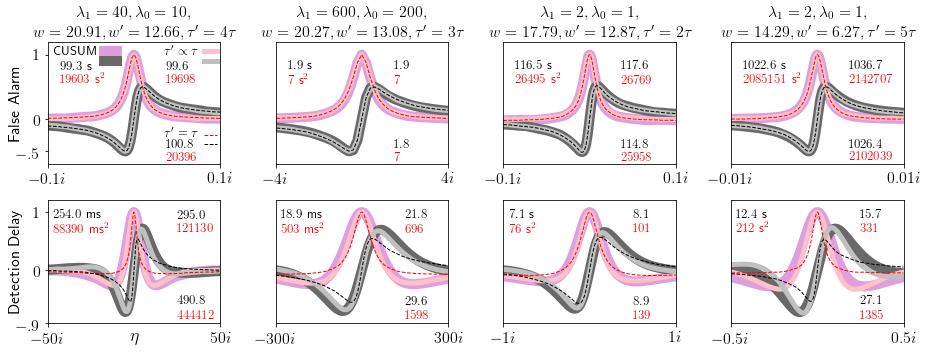

In [37]:
plt.figure(figsize=(13,5))

fa_xlim = [.1,4,.1,.01]; dd_xlim = [50,300,1,.5] 
L1_list = [40.,600.,2.,2.]; L0_list = [10.,200.,1.,1.]; 
w_list = [[20.91,20.27,17.79,14.29],[12.66,13.08,12.87,6.27]]; 
a_prop = [5,5,5,8]; match_list = [[1,1,1,1],[4,3,2,5]]

for j in range(len(L1_list)):

    L1 = L1_list[j]; L0 = L0_list[j]; w = w_list[0][j]; a = a_prop[j]; match = match_list[0][j]

    #load CUSUM simulation results
    filename = 'classic_L1_' + str(int(L1)) + '_L0_' + str(int(L0)) + \
                    '_a_' + str(int(a)) + '.npz'
    with np.load(filename) as data:
        ISI_fa = data['ISI_fa']; ISI_dd = data['ISI_dd']; a = data['a'];
        ES_FA_sim=data['ES_FA_sim']; ES_DD_sim=data['ES_DD_sim'];
        ES2_FA_sim=data['ES2_FA_sim']; ES2_DD_sim=data['ES2_DD_sim']
        t_c = data['t']

    #load LIFN simulation results - matching tau
    filename = 'LIFN_L1_' + str(int(L1)) + '_L0_' + str(int(L0)) + \
                    '_w_' + str(w) + '_match_' + str(match) + '.npz'
    with np.load(filename) as data:
        LIFN_fa = data['LIFN_ISI_fa']; LIFN_dd = data['LIFN_ISI_dd']; w = data['w'];
        LIFN_ES_FA = data['LIFN_ES_FA']; LIFN_ES_DD = data['LIFN_ES_DD']; 
        LIFN_ES2_FA = data['LIFN_ES2_FA']; LIFN_ES2_DD = data['LIFN_ES2_DD']
        t_l = data['t']
                
    #load LIFN simulation results - mismatched tau
    w2 = w_list[1][j]; a = a_prop[j]; match = match_list[1][j]
    
    filename = 'LIFN_L1_' + str(int(L1)) + '_L0_' + str(int(L0)) + \
                    '_w_' + str(w2) + '_match_' + str(match) + '.npz'
    with np.load(filename) as data:
        LIFN_fa_mm = data['LIFN_ISI_fa']; LIFN_dd_mm = data['LIFN_ISI_dd']; w2 = data['w'];
        LIFN_ES_FA_mm = data['LIFN_ES_FA']; LIFN_ES_DD_mm = data['LIFN_ES_DD']; 
        LIFN_ES2_FA_mm = data['LIFN_ES2_FA']; LIFN_ES2_DD_mm = data['LIFN_ES2_DD']
        t_l = data['t']
               
    #plot false alarms
    plt.subplot(2,4,j+1)
    plt.plot(np.imag(t_c),np.real(ISI_fa),'plum',ls='-',lw=10)
    plt.plot(np.imag(t_c),np.imag(ISI_fa),'dimgray',ls='-',lw=10)
    plt.plot(np.imag(t_l),np.real(LIFN_fa),'pink','r--',ls='-',lw=5)
    plt.plot(np.imag(t_l),np.imag(LIFN_fa),'silver','k--',ls='-',lw=5)
    plt.plot(np.imag(t_l),np.real(LIFN_fa_mm),'red',ls='--',lw=1)
    plt.plot(np.imag(t_l),np.imag(LIFN_fa_mm),'black',ls='--',lw=1)
    plt.xlim([-fa_xlim[j],fa_xlim[j]])
    plt.xticks([-fa_xlim[j],fa_xlim[j]],\
               [r'${}i$'.format(-fa_xlim[j]),r'${}i$'.format(fa_xlim[j])],fontsize=16)
    plt.ylim([-.7,1.2]); 
    if (j==0):
        plt.yticks([-.5,0,1],[r'$-.5$',r'$0$',r'$1$'],fontsize=16)
    else:
        plt.yticks([])
        
    plt.title(r'$\lambda_1 = {}$'.format(int(L1_list[j])) + r'$,  \lambda_0 = {},$'.format(int(L0_list[j])) +\
             '\n' + r'$w = {}$'.format(w) +\
              r"$,  w' = {}$".format(w2) + r"$,  \tau' = {} \tau$".format(match) ,fontsize=16)

    #CUSUM and LIFN first and second moments
    if (j == 0):
        plt.text(-.94*fa_xlim[j],1.,r'CUSUM',fontsize=13)
        plt.text(.35*fa_xlim[j],1.,r"$\tau' \propto \tau$",fontsize=13)
        plt.text(.35*fa_xlim[j],-.26,r"$\tau' = \tau$",fontsize=13)
        plt.ylabel(r'False Alarm',fontsize=16,labelpad=-6)
        #the legend
        x1 = np.linspace(-.035,-.02,10); y1 = 1.05*np.ones(len(x1))
        x2 = np.linspace(-.035,-.02,10); y2 = .9*np.ones(len(x1))
        plt.plot(x1,y1,'plum',lw=10); plt.plot(x2,y2,'dimgray',lw=10)
        
        x3 = np.linspace(.081,.096,10); y3 = 1.05*np.ones(len(x3))
        x4 = np.linspace(.081,.096,10); y4 = .9*np.ones(len(x4))
        plt.plot(x3,y3,'pink',lw=5); plt.plot(x4,y4,'silver',lw=5)
        
        x5 = np.linspace(.081,.096,10); y5 = -.24*np.ones(len(x5))
        x6 = np.linspace(.081,.096,10); y6 = -.39*np.ones(len(x6))
        plt.plot(x5,y5,'r--',lw=1); plt.plot(x6,y6,'k--',lw=1)
        
    if ES_FA_sim > 1:
        plt.text(-.86*fa_xlim[j],.78,r"${}$".format(round(ES_FA_sim,1))+r'$\text{ s}$',fontsize=13)
        plt.text(-.86*fa_xlim[j],.55,r"${}$".format(int(round(ES2_FA_sim)))+r'$\text{ s}^2$',fontsize=13,color='r')
        plt.text(.37*fa_xlim[j],.78,r"${}$".format(round(LIFN_ES_FA_mm,1)),fontsize=13)
        plt.text(.37*fa_xlim[j],.55,r"${}$".format(int(round(LIFN_ES2_FA_mm))),fontsize=13,color='r')
        plt.text(.37*fa_xlim[j],-.46,r"${}$".format(round(LIFN_ES_FA,1)),fontsize=13)
        plt.text(.37*fa_xlim[j],-.64,r"${}$".format(int(round(LIFN_ES2_FA))),fontsize=13,color='r')
    else:
        plt.text(-.86*fa_xlim[j],.78,r"${}$".format(round(ES_FA_sim*1000,1))+r'$\text{ ms}$',fontsize=13)
        plt.text(-.86*fa_xlim[j],.55,r"${}$".format(int(round(ES2_FA_sim*1000**2)))+r'$\text{ ms}^2$',fontsize=13,color='r')
        plt.text(.37*fa_xlim[j],.78,r"${}$".format(round(LIFN_ES_FA_mm*1000,1)),fontsize=13)
        plt.text(.37*fa_xlim[j],.55,r"${}$".format(int(round(LIFN_ES2_FA_mm*1000**2))),fontsize=13,color='r')
        plt.text(.37*fa_xlim[j],-.46,r"${}$".format(round(LIFN_ES_FA*1000,1)),fontsize=13)
        plt.text(.37*fa_xlim[j],-.64,r"${}$".format(int(round(LIFN_ES2_FA*1000**2))),fontsize=13,color='r')

    #plot detection delays
    plt.subplot(2,4,j+5)
    plt.plot(np.imag(t_c),np.real(ISI_dd),'plum',lw=10)
    plt.plot(np.imag(t_c),np.imag(ISI_dd),'dimgray',lw=10)
    plt.plot(np.imag(t_l),np.real(LIFN_dd_mm),'pink',ls='-',lw=5)
    plt.plot(np.imag(t_l),np.imag(LIFN_dd_mm),'silver',ls='-',lw=5)
    plt.plot(np.imag(t_l),np.real(LIFN_dd),'red',ls='--',lw=1)
    plt.plot(np.imag(t_l),np.imag(LIFN_dd),'black',ls='--',lw=1)
    plt.xlim([-dd_xlim[j],dd_xlim[j]])
    plt.ylim([-.9,1.2]); plt.yticks([]);
    plt.xticks([-dd_xlim[j],dd_xlim[j]],\
               [r'${}i$'.format(-dd_xlim[j]),r'${}i$'.format(dd_xlim[j])],fontsize=16)
    if (j==0):
        plt.xlabel(r'$\eta$',fontsize=18,labelpad=-18)
        plt.ylabel(r'Detection Delay',fontsize=16,labelpad=-6)
        #plt.legend(loc=1,bbox_to_anchor=(.9,.3,.15,1),ncol=3,fontsize=12,frameon=False)
        plt.yticks([-.9,0,1],[r'$-.9$',r'$0$',r'$1$'],fontsize=16)
    
    #CUSUM and LIFN first and second moments
    if ES_DD_sim > 1:
        plt.text(-.94*dd_xlim[j],.9,r"${}$".format(round(ES_DD_sim,1))+r'$\text{ s}$',fontsize=13)
        plt.text(-.94*dd_xlim[j],.65,r"${}$".format(int(round(ES2_DD_sim)))+r'$\text{ s}^2$',fontsize=13,color='r')
        plt.text(.50*dd_xlim[j],.9,r"${}$".format(round(LIFN_ES_DD_mm,1)),fontsize=13)
        plt.text(.50*dd_xlim[j],.65,r"${}$".format(int(round(LIFN_ES2_DD_mm))),fontsize=13,color='r')
        plt.text(.50*dd_xlim[j],-.58,r"${}$".format(round(LIFN_ES_DD,1)),fontsize=13)
        plt.text(.50*dd_xlim[j],-.83,r"${}$".format(int(round(LIFN_ES2_DD))),fontsize=13,color='r')
    else:
        plt.text(-.94*dd_xlim[j],.9,r"${}$".format(round(ES_DD_sim*1000,1))+r'$\text{ ms}$',fontsize=13)
        plt.text(-.94*dd_xlim[j],.65,r"${}$".format(int(round(ES2_DD_sim*1000**2)))+r'$\text{ ms}^2$',fontsize=13,color='r')
        plt.text(.50*dd_xlim[j],.9,r"${}$".format(round(LIFN_ES_DD_mm*1000,1)),fontsize=13)
        plt.text(.50*dd_xlim[j],.65,r"${}$".format(int(round(LIFN_ES2_DD_mm*1000**2))),fontsize=13,color='r')
        plt.text(.50*dd_xlim[j],-.58,r"${}$".format(round(LIFN_ES_DD*1000,1)),fontsize=13)
        plt.text(.50*dd_xlim[j],-.83,r"${}$".format(int(round(LIFN_ES2_DD*1000**2))),fontsize=13,color='r')
        
plt.tight_layout()
plt.savefig('fig5.pdf')

## One Optimal value of $\tau$ gives the closest fit between CUSUM and a LIFN

Fig. 6, main text

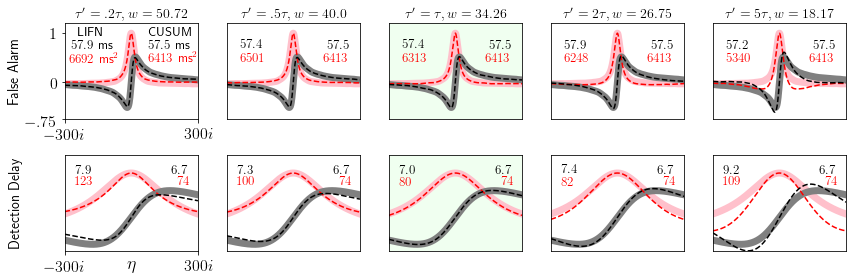

In [38]:
L1 = 600.; L0 = 200.

w_list = [50.72,40.00,34.26,26.75,18.17]; match_list = [.2,.5,1,2,5]
fa_xlim = 300; dd_xlim = 300;

plt.figure(figsize=(12,4))

for i in range(5):

    w = w_list[i]; match = match_list[i]
    
    #load CUSUM simulation results
    filename = 'classic_L1_' + str(int(L1)) + '_L0_' + str(int(L0)) + \
                    '_a_' + str(2) + '.npz'
    with np.load(filename) as data:
        ISI_fa = data['ISI_fa']; ISI_dd = data['ISI_dd']; t_c = data['t']
        ES_FA_sim=data['ES_FA_sim']; ES_DD_sim=data['ES_DD_sim'];
        ES2_FA_sim=data['ES2_FA_sim']; ES2_DD_sim=data['ES2_DD_sim']

    #load LIFN simulation results
    filename = 'LIFN_vary_L1_' + str(int(L1)) + '_L0_' + str(int(L0)) + \
                        '_w_' + str(w) +  '_match_' + str(match) + '.npz'
    with np.load(filename) as data:
        LIFN_ISI_fa = data['LIFN_ISI_fa']; LIFN_ISI_dd = data['LIFN_ISI_dd']; w = data['w'];
        LIFN_ES_FA = data['LIFN_ES_FA']; LIFN_ES_DD = data['LIFN_ES_DD']; 
        LIFN_ES2_FA = data['LIFN_ES2_FA']; LIFN_ES2_DD = data['LIFN_ES2_DD']; t_l = data['t']
        
    plt.subplot(2,5,1+i)
    plt.plot(np.imag(t_c),np.real(ISI_fa),'pink',lw=7)
    plt.plot(np.imag(t_c),np.imag(ISI_fa),'gray',lw=7)
    plt.plot(np.imag(t_l),np.real(LIFN_ISI_fa),'r--')
    plt.plot(np.imag(t_l),np.imag(LIFN_ISI_fa),'k--')
    plt.xlim([-fa_xlim,fa_xlim]); plt.ylim([-.75,1.2]); plt.xticks([])
    if i == 0:
        plt.yticks([-.75,0,1],[r'$-.75$',r'$0$',r'$1$'],fontsize=16); 
        plt.title(r"$\tau' = .2\tau, w = {}$".format(w),fontsize=14)
        plt.xlim([-fa_xlim,fa_xlim]); 
        plt.xticks([-fa_xlim,fa_xlim],[r'${}i$'.format(-fa_xlim),r'${}i$'.format(fa_xlim)],fontsize=16)
        plt.text(.25*fa_xlim,.95,r"CUSUM",fontsize=13); plt.text(-.8*fa_xlim,.95,r"LIFN",fontsize=13)
        plt.ylabel('False Alarm',fontsize=14)
    if i == 1:
        plt.yticks([]); plt.title(r"$\tau' = .5\tau, w = {}$".format(w),fontsize=14)
        plt.xlim([-fa_xlim,fa_xlim])
    if i == 2:
        plt.yticks([]); plt.title(r"$\tau' = \tau, w = {}$".format(w),fontsize=14) 
        plt.xlim([-fa_xlim,fa_xlim])
        ax = plt.gca(); ax.set_facecolor('honeydew')
    if i == 3:
        plt.yticks([]); plt.title(r"$\tau' = 2\tau, w = {}$".format(w),fontsize=14)
        plt.xlim([-fa_xlim,fa_xlim])
    if i == 4:
        plt.yticks([]); plt.title(r"$\tau' = 5\tau, w = {}$".format(w),fontsize=14)
        plt.xlim([-fa_xlim,fa_xlim])

    if i == 0:
        plt.text(.25*dd_xlim,.7,r"${}$".format(round(ES_FA_sim*1000,1)) + r'$\text{ ms}$',fontsize=13)
        plt.text(-.9*dd_xlim,.7,r"${}$".format(round(LIFN_ES_FA*1000,1)) + r'$\text{ ms}$',fontsize=13)
        plt.text(.25*dd_xlim,.4,"${}$".format(int(ES2_FA_sim*1000**2)) + r'$\text{ ms}^2$',fontsize=13,color='r')
        plt.text(-.94*dd_xlim,.4,r"${}$".format(int(LIFN_ES2_FA*1000**2)) +r'$\text{ ms}^2$',fontsize=13,color='r')
    else:
        plt.text(.5*fa_xlim,.7,r"${}$".format(round(ES_FA_sim*1000,1)),fontsize=13)
        plt.text(-.8*fa_xlim,.7,r"${}$".format(round(LIFN_ES_FA*1000,1)),fontsize=13)
        plt.text(.45*fa_xlim,.4,r"${}$".format(int(ES2_FA_sim*1000**2)),fontsize=13,color='r')
        plt.text(-.8*fa_xlim,.4,r"${}$".format(int(LIFN_ES2_FA*1000**2)),fontsize=13,color='r')

    plt.subplot(2,5,6+i)
    plt.plot(np.imag(t_c),np.real(ISI_dd),'pink',lw=7)
    plt.plot(np.imag(t_c),np.imag(ISI_dd),'gray',lw=7)
    plt.plot(np.imag(t_l),np.real(LIFN_ISI_dd),'r--')
    plt.plot(np.imag(t_l),np.imag(LIFN_ISI_dd),'k--')
    plt.xlim([-dd_xlim,dd_xlim]); plt.ylim([-.75,1.4]); plt.yticks([])
    if i == 0:
        plt.xticks([-dd_xlim,dd_xlim],[r'${}i$'.format(-dd_xlim),r'${}i$'.format(dd_xlim)],fontsize=16)
        plt.xlabel(r'$\eta$',fontsize=18,labelpad=-18)
        plt.ylabel('Detection Delay', fontsize=14, labelpad=42)
    else:
        plt.xticks([]);
    if i == 2:
        ax2 = plt.gca(); ax2.set_facecolor('honeydew')
        
    plt.text(.60*dd_xlim,1,r"${}$".format(round(ES_DD_sim*1000,1)),fontsize=13)
    plt.text(-.85*dd_xlim,1,r"${}$".format(round(LIFN_ES_DD*1000,1)),fontsize=13)
    plt.text(.68*dd_xlim,.73,"${}$".format(int(ES2_DD_sim*1000**2)),fontsize=13,color='r')
    plt.text(-.85*dd_xlim,.73,r"${}$".format(int(LIFN_ES2_DD*1000**2)),fontsize=13,color='r')

    
plt.tight_layout()
plt.savefig('fig6.pdf')

## Barn owl NLN results

Fig. 7, main text.

This code block also loads experimental results from another manuscript.  Those experimental results are the file "Funabiki.csv".  Its citation can be found in the caption of Fig. 6 in the manuscript.  Be sure that the data file that this block loads is in the same directory as this notebook.

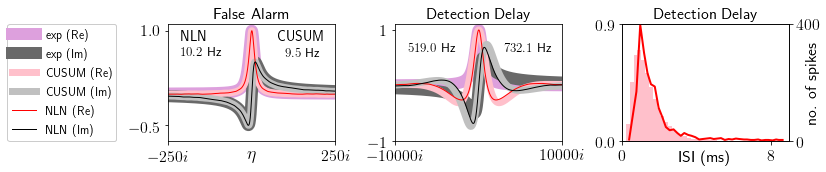

In [46]:
plt.figure(figsize=(12,2.5))

#load CUSUM simulation results
filename = 'NL.npz'
with np.load(filename) as data:
    FT_ISI_fa = data['FT_ISI_fa']; FT_ISI_dd = data['FT_ISI_dd'];
    FT_NL_fa = data['FT_NL_fa']; FT_NL_dd = data['FT_NL_dd'];
    tnl_fa = data['tnl_fa']; tnl_dd = data['tnl_dd'];
    ISI_fa = data['ISI_fa']; ISI_dd = data['ISI_dd'];
    ES_fa = data['ES_fa']; ES_dd = data['ES_dd']; 
    NLN_fa = data['NLN_fa']; NLN_dd = data['NLN_dd'];
    page_fa = data['page_fa']; page_dd = data['page_dd']

plt.subplot(1,3,1)
plt.plot(np.imag(tnl_fa),np.real(page_fa),'plum',lw=12,label='exp (Re)')
plt.plot(np.imag(tnl_fa),np.imag(page_fa),'dimgray',lw=12,label='exp (Im)')
plt.plot(np.imag(tnl_fa),np.real(FT_ISI_fa),'pink',lw=7,label='CUSUM (Re)')
plt.plot(np.imag(tnl_fa),np.imag(FT_ISI_fa),'silver',lw=7,label='CUSUM (Im)')
plt.plot(np.imag(tnl_fa),np.real(FT_NL_fa),'r',lw=1,label='NLN (Re)')
plt.plot(np.imag(tnl_fa),np.imag(FT_NL_fa),'k',lw=1,label='NLN (Im)')
plt.xlim([-250,250]); plt.xticks([-250,250],[r'$-250i$',r'$250i$'],fontsize=16)
plt.ylim([-.75,1.1]); plt.yticks([-.5,1],fontsize=16)
plt.xlabel(r'$\eta$',fontsize=18,labelpad=-18)
plt.legend(bbox_to_anchor=(-1,.4,.02,.2), loc="center left", ncol=1, fontsize=12, framealpha=1)
plt.title('False Alarm',fontsize=16)

plt.text(-.85*250,.85,r"NLN",fontsize=14)
plt.text(.3*250,.85,r"CUSUM",fontsize=14)
plt.text(.4*250,.6,r"${}$".format(round(ES_fa,1)) + r"$\text{ Hz}$",fontsize=13)
plt.text(-.85*250,.6,r"${}$".format(round(NLN_fa,1)) + r"$\text{ Hz}$",fontsize=13)


plt.subplot(1,3,2)
plt.plot(np.imag(tnl_dd),np.real(page_dd),'plum',lw=12)
plt.plot(np.imag(tnl_dd),np.imag(page_dd),'dimgray',lw=12)
plt.plot(np.imag(tnl_dd),np.real(FT_ISI_dd),'pink',lw=7)
plt.plot(np.imag(tnl_dd),np.imag(FT_ISI_dd),'silver',lw=7)
plt.plot(np.imag(tnl_dd),np.real(FT_NL_dd),'r',lw=1)
plt.plot(np.imag(tnl_dd),np.imag(FT_NL_dd),'k',lw=1)
plt.xlim([-10000,10000]); plt.xticks([-10000,10000],[r'$-10000i$',r'$10000i$'],fontsize=16)
plt.ylim([-1,1.1]); plt.yticks([-1,1],fontsize=16)
plt.title('Detection Delay',fontsize=16)

plt.text(.3*10000,.6,r"${}$".format(round(ES_dd,1)) + r"$\text{ Hz}$",fontsize=13)
plt.text(-.85*10000,.6,r"${}$".format(round(NLN_dd,1)) + r"$\text{ Hz}$",fontsize=13)

#units of ISIs in milliseconds
FA = 1000*np.array(ISI_fa); DD = 1000*np.array(ISI_dd)

#load experimental data
fun_x=[]; fun_y=[]; fun_x_shift=[]
with open('Funabiki.csv', 'r') as csvfile:
    plots= csv.reader(csvfile, delimiter=',')
    for row in plots:
        fun_x.append(float(row[0]))
        fun_y.append(float(row[1]))
        fun_x_shift.append(float(row[0])-.3)

ax3 = plt.subplot(1,3,3)
ax3.hist(DD,bins=np.linspace(0,8,40),density=True,color='pink');
ax3.set_xticks([0,8]); 
ax3.set_xlabel(r'ISI (ms)',fontsize=16,labelpad=-14)
ax3.set_yticks([0,.9])
ax3.set_title(r'Detection Delay',fontsize=16)
ax3.tick_params(axis='x',labelsize=16); ax3.tick_params(axis='y',labelsize=16)

ax4 = ax3.twinx()
ax4.set_xlim([0,9])
ax4.set_ylabel('no. of spikes',fontsize=16,labelpad=-16)
ax4.plot(fun_x, fun_y,color='r',ls='-',lw=2)
ax4.set_yticks([0,400]); ax4.set_ylim([0,400])
ax4.tick_params(axis='y', labelsize=16)

plt.tight_layout()
plt.savefig('fig7.pdf')